## Goal: Indexes for the flash drougth project

In this notebook, I am working to a script the calculates indexes we need for the flash drougth project. These will be timeseries for the area-integrated Rhine basin. 


### The indexes we need are: 

- SPI standardized precipitation index. Variable: precipitation
- SPEI standardized precipitation/evapotranspiration index. Variable: precipitation - potential evapotranspiration
- ESI/SESR evaporative stress index/standardized evaporative stress ratio. Variable: evapotranspiration/potential evapotranspiration
- SMI soil moisture index. Variable: soil moisture

### Input variables for the script

- Variable to standardize 
- Time scale (For now we test all variables for 7, 14, 21, 28 day time scales)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# import functions (and packages) from R
r_time_series = robjects.r('ts')

In [11]:
def read_in_ERA5(var, diri, basin):
    ds = xr.open_mfdataset(f'{diri}/{var}_{basin}_198*.nc')
    da = ds[var]
    return da

In [12]:
def make_index_timeseries(var, diri,basin):
    if var == 'pr' or var == 'mrsos':
        da = read_in_ERA5(var, diri, basin)
    elif var == 'wb':
        da_pr = read_in_ERA5('pr', diri, basin)
        da_pet = read_in_ERA5('pet', diri, basin)
        da = da_pr - da_pet
    elif var == 'es':
        da_et = read_in_ERA5('et', diri, basin)
        da_pet = read_in_ERA5('pet', diri, basin)
        da = da_et / da_pet        
    return da

In [35]:
def calc_standardized_index_daily(da, scale):
    SPEI_package = importr('SPEI')
    r_spei_function = robjects.r['spei']

    # convert to R timeseries
    r_da = r_time_series(robjects.FloatVector(da.values), start = robjects.IntVector([da.time.dt.year[0].values, da.time.dt.month[0].values]), frequency = 365)
    r_standardized_index = r_spei_function(r_da, scale=scale, na_rm=True, distribution='log-Logistic',verbose=False)


    # put standardized index in DataArray
    da_standardized_index = da.copy(deep=True)
    da_standardized_index.values = xr.DataArray(pandas2ri.ri2py_vector(r_standardized_index.rx2('fitted')))
    
    return da_standardized_index

In [69]:
def calc_index_to_netcdf(var, diri, diro, basin, scale):

    da = make_index_timeseries(var, diri,basin)
    da_standardized_index = calc_standardized_index_daily(da, scale)

    # define data with variable attributes as Xarray dataset

    if var == 'pr':
        indexname = 'SPI'
    elif var == 'mrsos':
        indexname = 'SMI'
    elif var == 'wb':
        indexname = 'SPEI'
    elif var == 'es':
        indexname = 'ESI'


    var_attr = {'units': '-', 
                        'standard_name': f'{indexname}_{scale}d',
                        'long_name': f'{indexname} standardized index of {var} (scale: {scale}d)',
                        }

    coords={'time': (['time'], da_standardized_index.time.data, da_standardized_index.time.attrs)}
              
    ds_new = xr.Dataset(
    data_vars=dict(
        index=(['time'],  
                      da_standardized_index.data, 
                       var_attr,
    )),
    coords=coords
    )

    ds_new.time.encoding = {'zlib': False,
                        'shuffle': False,
                        'complevel': 0,
                        'fletcher32': False,
                        'contiguous': False,
                        'dtype': np.dtype('float64'),
                        'units': 'days since 1850-01-01 00:00:00',
                        'calendar': 'proleptic_gregorian'
                        }

    ds_new.index.encoding = {'_FillValue': np.nan,
                'missing_value':np.nan,
                'dtype': np.dtype('float64'),
                'zlib': False
            }

    ds_new.to_netcdf(f'{diro}/{indexname}_test.nc')


In [73]:
def main():
    basin = 'Rhine'
    diri='/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
    diro = '/scratch/nklm/Px_flashdroughts/indices_ERA5'
    for var in ['pr','mrsos','wb','es']:
        for scale in [7,14,21,28]:
            calc_index_to_netcdf(var, diri, diro, basin, scale)


In [75]:
if __name__ == '__main__':
    sys.exit(main())

7
14
21
28


In [28]:
da_standardized_index

<xarray.DataArray (dim_0: 3650)>
array([        nan,         nan,         nan, ..., -0.26608539,
       -0.74296167, -1.26972563])
Dimensions without coordinates: dim_0

In [29]:
da_copy = da.copy(deep=True)

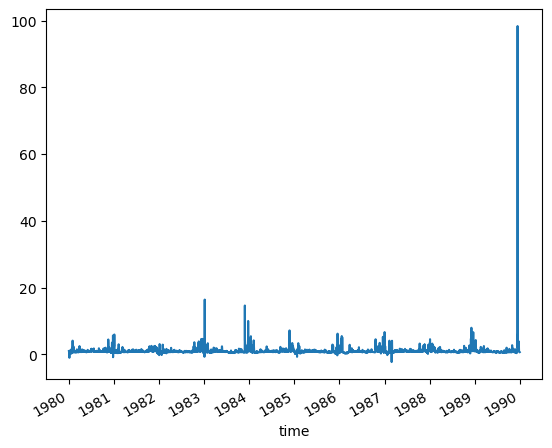

In [32]:
da_copy.plot()

In [33]:
da_copy.values = da_standardized_index.values

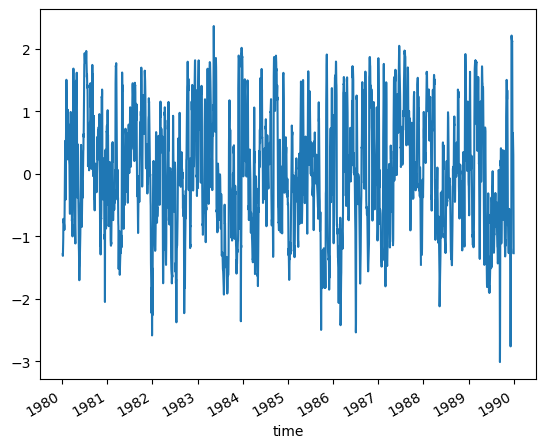

In [34]:
da_copy.plot()

In [60]:
calc_index_to_netcdf('es', diri, basin, scale)

TypeError: Invalid value for attr 'dtype': dtype('float64'). For serialization to netCDF files, its value must be of one of the following types: str, Number, ndarray, number, list, tuple

In [70]:
calc_index_to_netcdf('es', diri, basin, scale)

TypeError: data type 'ndarray' not understood

In [71]:
type(da_standardized_index) # = calc_standardized_index_daily(da, scale)

xarray.core.dataarray.DataArray

In [43]:
da_standardized_index[0:10]

<xarray.DataArray (time: 10)>
array([        nan,         nan,         nan,         nan,         nan,
               nan, -1.28519195, -1.31210687, -1.23941948, -1.12677793])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T11:00:00 ... 1980-01-10T11:00:00

In [13]:
da = make_index_timeseries('es', diri,basin)

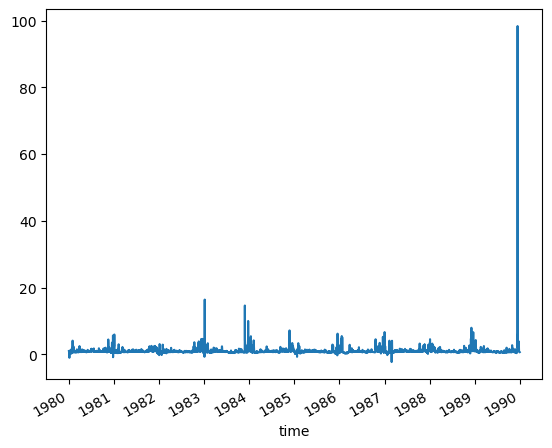

In [22]:
da.plot()